cfr      151.766495
cfr14     28.350868
dtype: float64


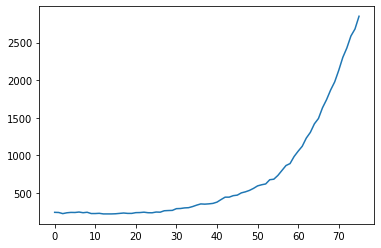

<Figure size 432x288 with 0 Axes>

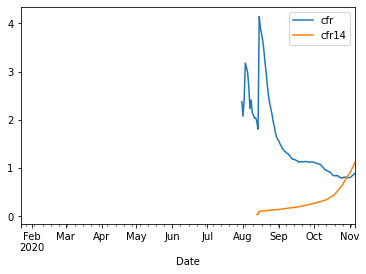

In [37]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("time-series-19-covid-combined.csv", index_col='Date', parse_dates=True, dayfirst=False) 
data_rki = pd.read_json("rki.json")
#for country in data['Country/Region'].unique():
#    print(country)
# Preview the first 5 lines of the loaded data 
data = data[data['Country/Region']=='Italy']
#data = data[data['Country/Region']=='Germany']
#data = data[data['Country/Region']=='US']
#data = data[data['Country/Region']=='Czechia']
data['CM10']=data['Confirmed'].shift(10)
# Daten der letzen 100 Tage
dd=data['Deaths'][-100:]
dc=data['Confirmed'][-100:]
dd=dd-dd[0]
dc_14=dc.shift(14)
dc=dc-dc[0]
data['cfr']=100*dd/dc
data['cfr14']=100*dd/dc_14
data['ineu']=data['Confirmed'].diff(1)
data['ineu10']=data['CM10'].diff(1)
data['mki']=0.06*data['ineu']
data['dneu']=data['Deaths'].diff(1)

# Infektionsrate ist: wieviele wurden heute gegenüber der letzten Zeit neu infiziert
# berechne ich mal mit Mittelwert gestern und heute im Verhältnis zu Mittelwert der 
# letzten drei Tage (gestern vorgestern und vorvorgestern)
data['avg_new_2d']=data['ineu'].rolling(2).mean()
data['avg_new_l3d']=data['ineu'].shift(1).rolling(5).mean()
data['infection_rate']=data['avg_new_2d']/data['avg_new_l3d']

#data['cfr']=100*data['dneu']/data['ineu']
#data['cfr10']=100*data['dneu']/data['ineu10']
# data.head()
d = data[['cfr','cfr14']]
#d = data['infection_rate']
#d = data['dneu']
#print(d[-14:])
#d = d.rolling(5).median()
#d = data['Deaths'].diff(1).rolling(7).median()
print(d.sum())
plt.figure()
p = d.plot()
#p.set_yscale('log')
#p.set_ylim(0,20)

#d.plot(kind='bar')

#print(data['ineu'].sum()*0.06)

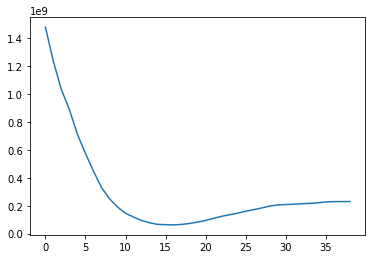

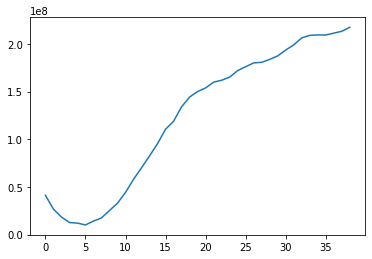

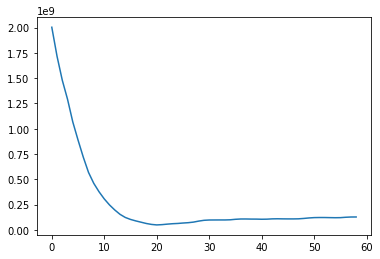

In [76]:
def get_corr( data, idx1, idx2, tage, max_tage):
    # von beiden Indizes die letzten 90 Tage und index 1 shiften um X Tage
    max_len = data[idx1].size
    max_len -= tage
    max_len = min([max_len,max_tage])
    data_1 = data[idx1].shift(tage)[-max_len:]
    data_2 = data[idx2][-max_len:]
    ## normalisieren
    #data_1 = (data_1-data_1.min())/(data_1.max()-data_1.min())
    #data_2 = (data_2-data_2.min())/(data_2.max()-data_2.min())
    diff = data_1-data_2
    diff_2 = diff*diff
    return diff_2.sum()

def get_corr2( data_1, data_2, tage, max_len):
    # von beiden Indizes die letzten 90 Tage und index 1 shiften um X Tage
    d1 = data_1.shift(tage)
    d1 = d1[-max_len:]
    d2 = data_2[-max_len:]
    ## normalisieren
    diff = d1-d2
    diff_2 = diff*diff
    return diff_2.sum()


data = pd.read_csv("time-series-19-covid-combined.csv", index_col='Date', parse_dates=True, dayfirst=False) 
data = data[data['Country/Region']=='Germany']
data_rki = pd.read_json("rki.json", convert_dates=True)
data_rki = data_rki.set_index('dates', drop=True)
data = data.join( data_rki )

# Annahme: 2% Krankenhaus, 1% Tote
data_1 = data['Confirmed'][-100:].diff(1).rolling(5).mean()
data_2 = (data['faelle']/0.02).diff(1).rolling(5).mean()
data_3 = (data['Deaths']/0.02).diff(1).rolling(5).mean()

diffs=[]
for latenz in range( 1, 40):
    diffs.append( get_corr2( data_1, data_2, latenz, 90))

plt.figure()
plt.plot(diffs)


diffs=[]
for latenz in range( 1, 40):
    diffs.append( get_corr2( data_2, data_3, latenz, 90))

plt.figure()
plt.plot(diffs)

diffs=[]
for latenz in range( 1, 60):
    diffs.append( get_corr2( data_1, data_3, latenz, 90))

plt.figure()
plt.plot(diffs)




0      1
1      2
2      2
3      8
4      7
5      4
6      5
7      6
8      2
9      3
10     4
11     4
12     5
13     6
14    10
15    10
16    10
17     2
18     4
Name: t1, dtype: int64
0      NaN
1      NaN
2      1.0
3      2.0
4      2.0
5      8.0
6      7.0
7      4.0
8      5.0
9      6.0
10     2.0
11     3.0
12     4.0
13     4.0
14     5.0
15     6.0
16    10.0
17    10.0
18    10.0
Name: t1, dtype: float64
0      NaN
1      NaN
2      1.0
3      2.0
4      2.0
5      8.0
6      7.0
7      4.0
8      5.0
9      6.0
10     2.0
11     3.0
12     4.0
13     4.0
14     5.0
15     6.0
16    10.0
17    10.0
18    10.0
Name: t1, dtype: float64


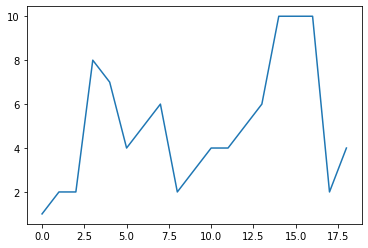

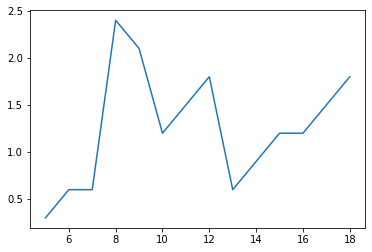

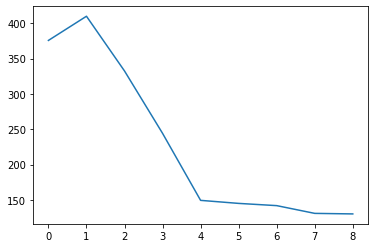

In [56]:
b = [1,2,2,8,7,4,5,6,2,3,4,4,5,6,10,10,10,2,4]
b=pd.DataFrame(b,columns =['t1'])
b['t2'] = b['t1'].shift(5)*0.3

plt.figure()
plt.plot(b['t1'])

plt.figure()
plt.plot(b['t2'])

diffs=[]
for latenz in range( 1, 10):
    diffs.append( get_corr( b, 't1', 't2', latenz, 100))

plt.figure()
plt.plot(diffs)

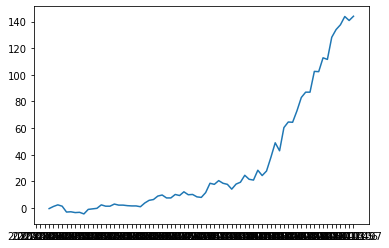

In [63]:
data_rki = pd.read_json("rki.json", convert_dates=True)
data_rki = data_rki.set_index('dates', drop=True)

data_rki['steigerung'] = data_rki['faelle'].diff(1).rolling(5).mean()
plt.figure()
plt.plot(data_rki['steigerung'])